In [1]:
import numpy as np                                                      #import libraries needed
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
# module to ignore warnings
import warnings
warnings.filterwarnings('ignore')

train_data = pd.read_csv('train.csv')                                    #read data from 'train.csv' file to train_data
train_data.head(10)                                                      #show first 10 rows of data

,X,Y
0,-5.0,-6.32040
1,-4.8,-4.30980
2,-4.6,-3.57990
3,-4.4,-3.12940
4,-4.2,-2.32630
5,-4.0,-1.98010
6,-3.8,-1.86750
7,-3.6,-1.74340
8,-3.4,-0.59197
9,-3.2,-1.28840


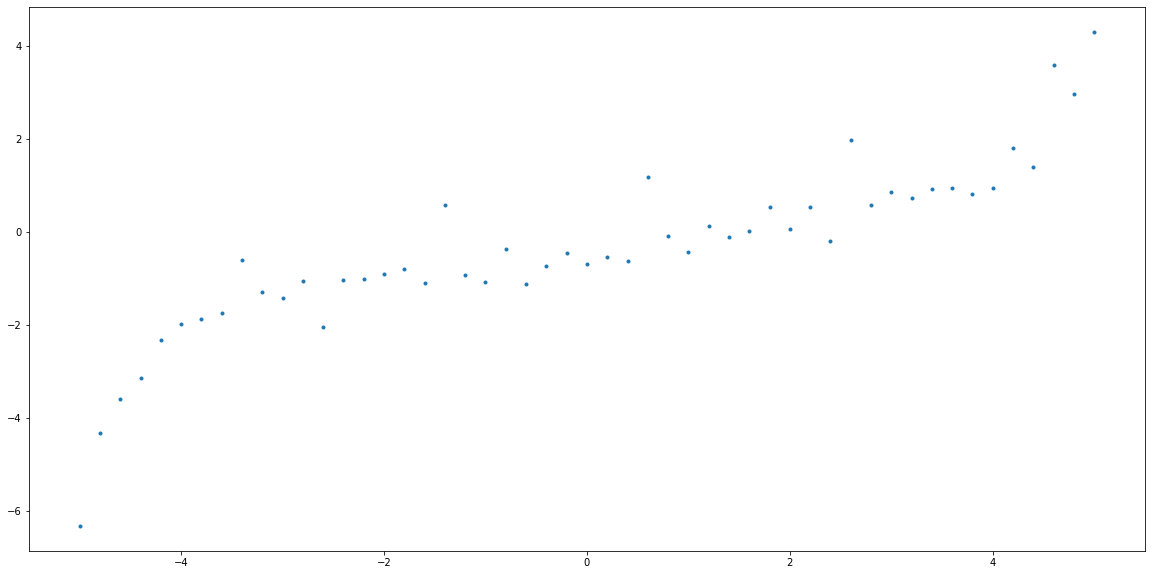

In [3]:
plt.plot(train_data['X'],train_data['Y'],'.')          #plot X values vs Y values from train_train data

# Linear Regression

Text(0.5, 1.0, 'Plot for linear regression')

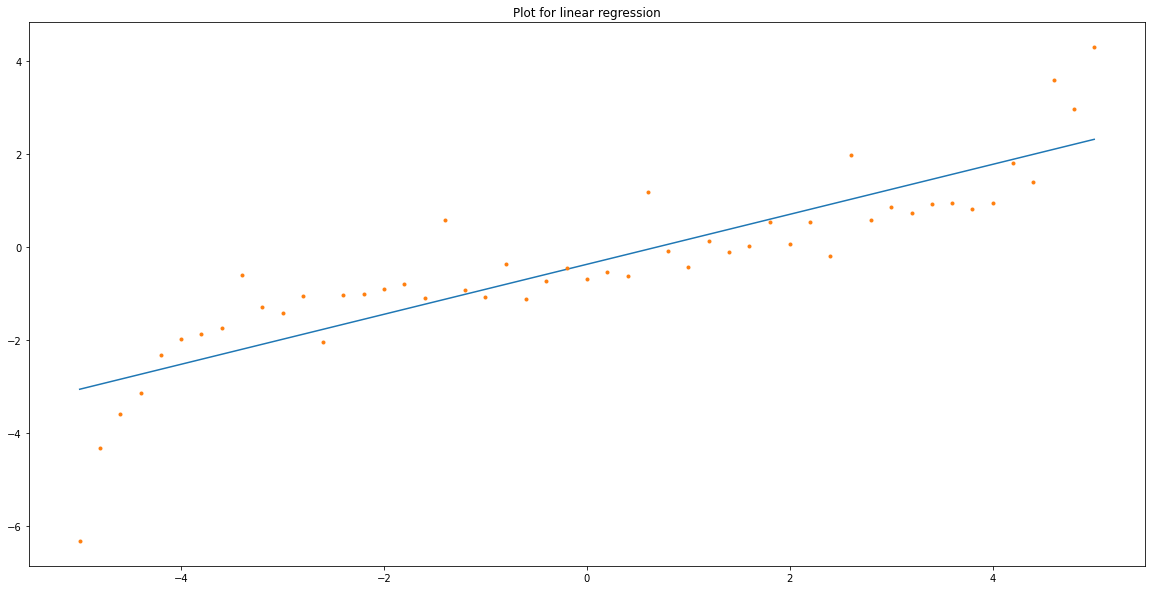

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

feature= ['X']                                                        #define a variable features that can be used for training
linear = LinearRegression(normalize=True)
linear.fit(train_data[feature], train_data['Y'])                      #fit the X values and Y values with linear regressor                          
y_pred = linear.predict(train_data[feature])                       #predict the values with the model

plt.plot(train_data['X'],y_pred)                                      #plot X vs Y_pred and X vs Y actual
plt.plot(train_data['X'],train_data['Y'],'.')
plt.title('Plot for linear regression')

In [5]:
mse = mean_squared_error(train_data['Y'], y_pred)           #calculate mean square error
parameters=[mse]                                            #define an array parameters that should keep the values for analysis
parameters.extend([linear.intercept_])                      #add intercept to the array parameters
parameters.extend(linear.coef_)                             #add coeficient of X to the parameters array

pd.DataFrame(parameters, index=['MSE','Intercept','Coef_X'])

,0
MSE,0.756831
Intercept,-0.370317
Coef_X,0.537251


In [6]:
test_data= pd.read_csv('testX.csv')                        #read test data from 'testX.csv' file to test_data
submission=pd.read_csv('submission.csv')                   #read 'submission.csv' file 
test_data=test_data.rename(columns={'Xts':'X'})            #rename the columns 
submission=submission.rename(columns={'Xts':'X_test', 'Yp':'Y_test_linear'})


testY_pred = linear.predict(test_data[feature])           #predict Y values for test data
submission['Y_test_linear'] = testY_pred.reshape(-1,1)    #save the data to submission dataframe to the column 'Y_test_linear'
submission.to_csv('submission.csv',index=False)           #write the result to the 'submission.csv' file


# Ridge Regression

In [7]:
#introducing higher powers of X as features(X^2 to X^15) for train_data

for i in range(2,16):  
    colname = 'X^%d'%i                 #defining column name as X^2 to X^15
    train_data[colname] = train_data['X']**i       #update the columns with higher powers of X


In [8]:
#introducing higher powers of X as features(X^2 to X^15) for test_data

for i in range(2,16):  
    colname = 'X^%d'%i                                                #defining column name as X^2 to X^15
    test_data[colname] = test_data['X']**i


In [9]:
#define a function to select features as higher power of X

def feature_selection(power, alpha):
    features = ['X']                                                #define feature array with column names like X, X^1, X^2 ..
    
    if power>=2:
        features.extend(['X^%d'%i for i in range(2,power+1)])                 
    
    col = ['MSE', 'intercept'] + ['coef_X^%d'%i for i in range(1,power+1)]   #define dataframe for holding different parameters 
    row= ['alpha_%.2g'%alpha[i] for i in range(0,3)]                         #like mse, intercept, coeficients of X terms
    coef_matrix= pd.DataFrame(index=row, columns=col)
    return features, coef_matrix


In [10]:
from sklearn.linear_model import Ridge


#define a function for doing Ridge regression for different values of alpha
def ridge_model(data,test_data,submission,features,alpha):
    
    ridge = Ridge(alpha=alpha, normalize=True)
    ridge.fit(data[features], data['Y'])                               #fit the model with ridge regressor
    Y_pred= ridge.predict(data[features])                              #predict the values with the Ridge model
    
    if alpha == 1e-15:
        testY_pred = ridge.predict(test_data[features])                #for alpha=1e-15 predict the Y values for test_data
        submission['Y_test_ridge'] = testY_pred.reshape(-1,1)          #update this values in the submission dataframe
        plt.plot(data['X'],Y_pred)                                     #with column name 'Y_test_ridge'
        plt.plot(data['X'],data['Y'],'.')                              #plot y predicted and Y actual for train data for 
        plt.title('Plot for Ridge Regression, alpha: %.3g)'%alpha)     #alpha=1e-15
        
    mse = mean_squared_error(data['Y'], Y_pred)                        #fine mean square error for train_data
    parameters=[mse]
    parameters.extend([ridge.intercept_])                              #update the values in the parameters array
    parameters.extend(ridge.coef_)
    
    return parameters, submission


Ridge Regression without X power terms


,MSE,intercept,coef_X^1
alpha_1e-15,0.76,-0.37,0.54
alpha_0.01,0.76,-0.37,0.53
alpha_5,2.5,-0.37,0.09


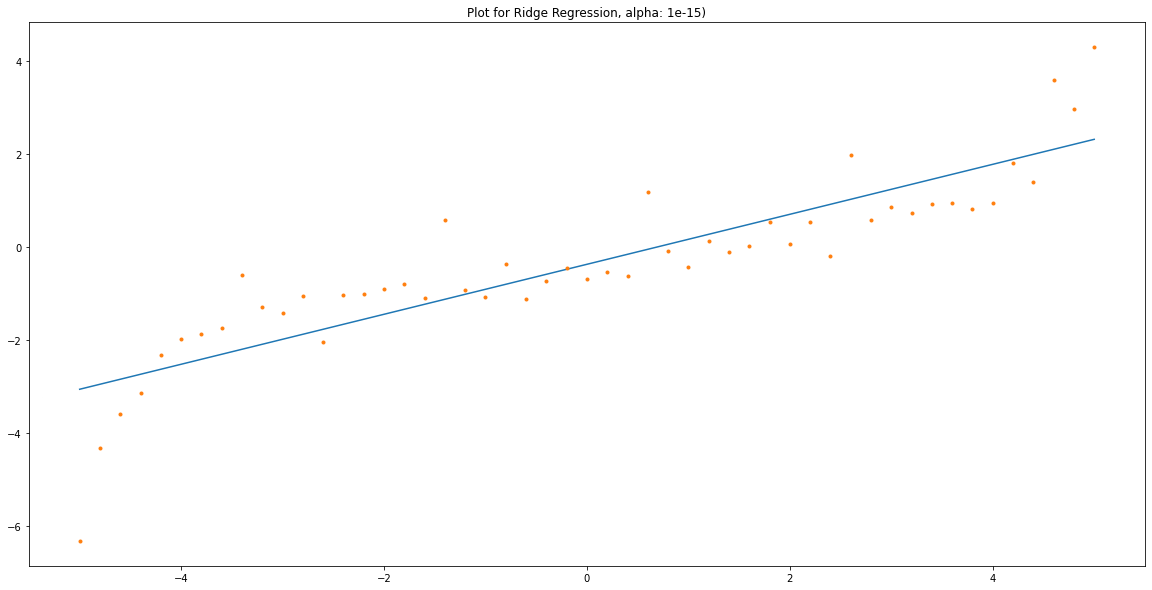

In [11]:
ridge_alpha=ridge_alpha= [1e-15, 0.01, 5]                            #define alpha values going to use
features, ridge_coef_matrix=feature_selection(1, ridge_alpha)        #call a feture_selection function with no powers used

#itrate for all values of alpha and record the result
for i in range(3):
    ridge_coef_matrix.iloc[i,:], submission = ridge_model(train_data,test_data,submission,features,ridge_alpha[i])

    
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
print("Ridge Regression without X power terms")
ridge_coef_matrix

Ridge Regression with X power terms upto 15


,MSE,intercept,coef_X^1,coef_X^2,coef_X^3,coef_X^4,coef_X^5,coef_X^6,coef_X^7,coef_X^8,coef_X^9,coef_X^10,coef_X^11,coef_X^12,coef_X^13,coef_X^14,coef_X^15
alpha_1e-15,0.19,-0.56,0.91,0.5,-0.78,-0.26,0.29,0.057,-0.048,-0.0061,0.004,0.00033,-0.00018,-8.9e-06,3.9e-06,9.4e-08,-3.5e-08
alpha_0.01,0.23,-0.38,0.3,0.02,0.0015,-0.00079,2.8e-05,-1.6e-05,6.5e-06,1.6e-07,4.4e-07,1.6e-08,1.9e-08,-1.4e-10,6.2e-10,-7.7e-11,1.5e-11
alpha_5,0.86,-0.33,0.053,-0.00051,0.003,-4.7e-05,0.00014,-2.5e-06,5.8e-06,-1.2e-07,2.4e-07,-5.3e-09,9.7e-09,-2.3e-10,3.9e-10,-9.8e-12,1.6e-11


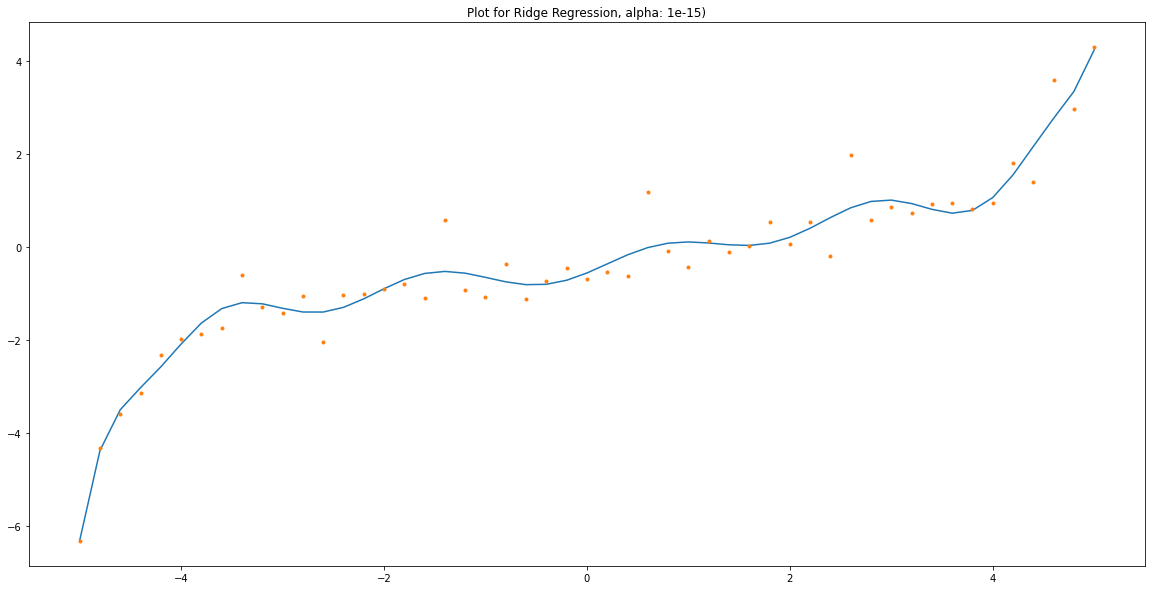

In [12]:
features, ridge_coef_matrix=feature_selection(15, ridge_alpha) #call a feture_selection function with all powers upto 15 used

#itrate for all values of alpha and record the result
for i in range(3):
    ridge_coef_matrix.iloc[i,:], submission = ridge_model(train_data,test_data,submission,features,ridge_alpha[i])

    
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
print("Ridge Regression with X power terms upto 15")
ridge_coef_matrix

In [ ]:
#by analysing 'ridge_coef_matrix' we can conclude that there is no much effect on powers beyond 7
#so remove that columns from the feature array
#do the same process and update Y_predicted in submission file with this features

Ridge Regression with X power terms upto 7


,MSE,intercept,coef_X^1,coef_X^2,coef_X^3,coef_X^4,coef_X^5,coef_X^6,coef_X^7
alpha_1e-15,0.22,-0.41,0.3,0.039,0.022,-0.0021,-0.0032,-5.6e-06,0.00014
alpha_0.01,0.24,-0.38,0.31,0.023,-0.006,-0.00062,0.00015,-4.2e-05,4.7e-05
alpha_5,1.3,-0.34,0.063,-0.0011,0.0039,-7.9e-05,0.00019,-4.1e-06,8.3e-06


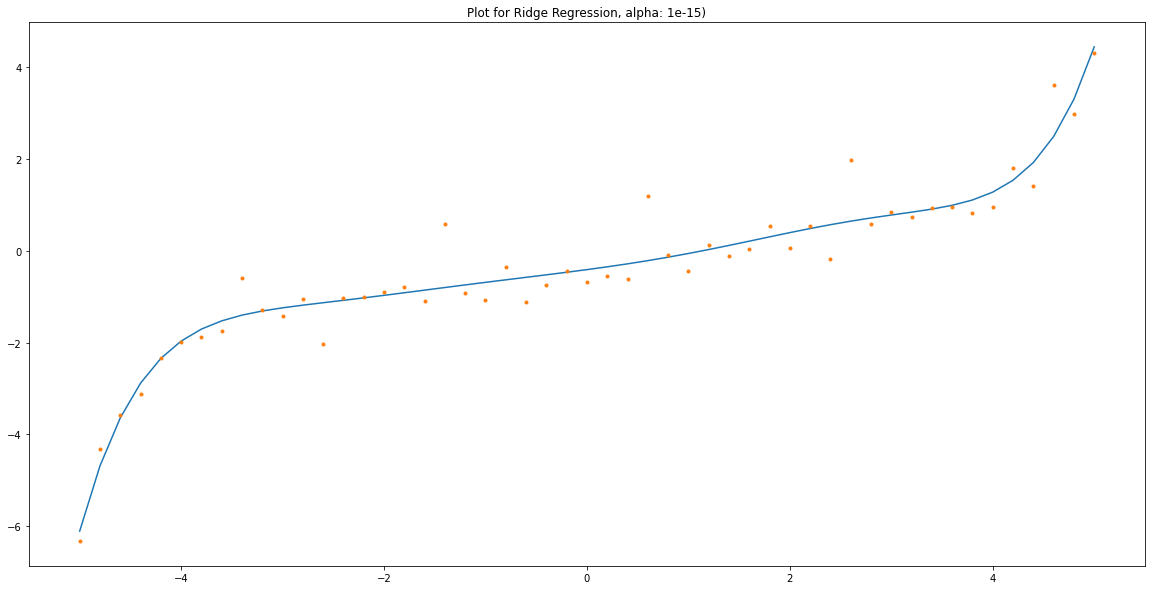

In [13]:
features, ridge_coef_matrix=feature_selection(7, ridge_alpha)  #call a feture_selection function with all powers upto 7 used


#itrate for all values of alpha and record the result
for i in range(3):
    ridge_coef_matrix.iloc[i,:], submission = ridge_model(train_data,test_data,submission,features,ridge_alpha[i])

    
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
print("Ridge Regression with X power terms upto 7")
ridge_coef_matrix

# Lasso

In [14]:
from sklearn.linear_model import Lasso

def lasso_model(data,test_data,submission,features,alpha):
    
    lasso = Lasso(alpha=alpha, normalize=True)
    lasso.fit(data[features], data['Y'])                        #fit the model with lasso regression
    Y_pred= lasso.predict(data[features])                       #predict the values for train_data
    
    if alpha == 1e-15:
        testY_pred = lasso.predict(test_data[features])         #for alpha=1e-15 predict the Y values for test_data
        submission['Y_test_lasso'] = testY_pred.reshape(-1,1)   #update this values in the submission dataframe
        plt.plot(data['X'],Y_pred)                              #with column name 'Y_test_lasso'
        plt.plot(data['X'],data['Y'],'.')                       #plot y predicted and Y actual for train data for alpha=1e-15
        plt.title('Plot for Lasso Regression, alpha: %.3g)'%alpha)
        
    mse = mean_squared_error(data['Y'], Y_pred)                #fine mean square error for train_data
    parameters=[mse]                                           #update the values in the parameters array
    parameters.extend([lasso.intercept_])
    parameters.extend(lasso.coef_)
    
    return parameters, submission


Lasso Regression without X power terms


,MSE,intercept,coef_X^1
alpha_1e-15,0.76,-0.37,0.54
alpha_0.01,0.76,-0.37,0.51
alpha_5,3.3,-0.37,0


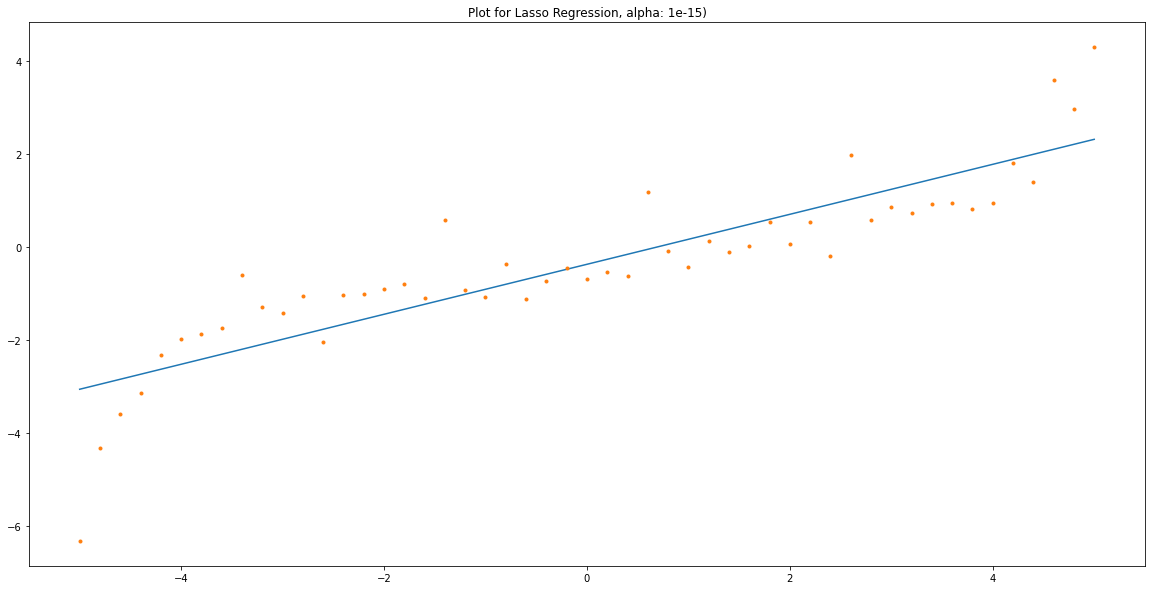

In [16]:
lasso_alpha=ridge_alpha= [1e-15, 0.01, 5]                        #define different values of alpha
features, lasso_coef_matrix=feature_selection(1, lasso_alpha)    #call a feture_selection function with no powers used

#itrate for all values of alpha and record the result
for i in range(3):
    lasso_coef_matrix.iloc[i,:], submission = lasso_model(train_data,test_data,submission,features,lasso_alpha[i])


    
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
print("Lasso Regression without X power terms")
lasso_coef_matrix

Lasso Regression with X power terms upto 15


,MSE,intercept,coef_X^1,coef_X^2,coef_X^3,coef_X^4,coef_X^5,coef_X^6,coef_X^7,coef_X^8,coef_X^9,coef_X^10,coef_X^11,coef_X^12,coef_X^13,coef_X^14,coef_X^15
alpha_1e-15,0.22,-0.44,0.36,0.079,-0.0039,-0.008,-0.00042,0.00011,2.7e-05,6.2e-06,1.2e-06,1.3e-07,2.4e-08,-2.4e-09,2.5e-11,-3.8e-10,-1.8e-11
alpha_0.01,0.24,-0.35,0.3,-0,0,-0,0,-0,0,-0,1.4e-06,-0,1.7e-08,-0,0,-4.8e-11,0
alpha_5,3.3,-0.37,0,-0,0,-0,0,-0,0,-0,0,-0,0,-0,0,-0,0


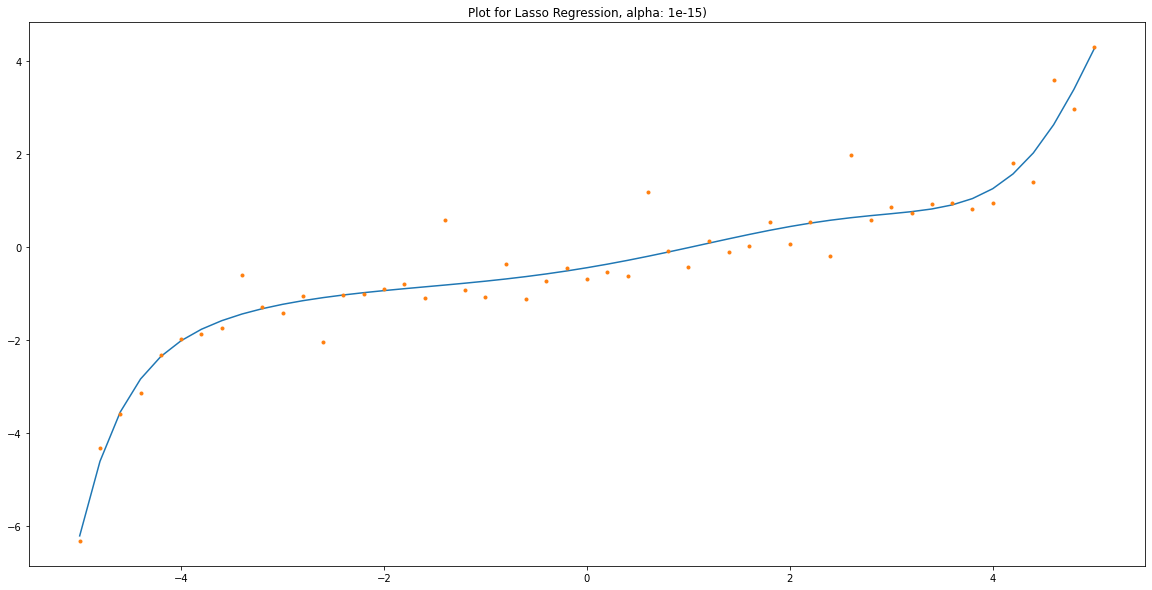

In [17]:
features,lasso_coef_matrix=feature_selection(15, lasso_alpha)  #call a feture_selection function with all powers upto 15 used


#itrate for all values of alpha and record the result
for i in range(3):
    lasso_coef_matrix.iloc[i,:], submission = lasso_model(train_data,test_data,submission,features,lasso_alpha[i])

    
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
print("Lasso Regression with X power terms upto 15")
lasso_coef_matrix

In [94]:
#by analysing 'lasso_coef_matrix' we can conclude that there is no much effect on powers beyond 4 
#so remove that columns from the feature array
#do the same process and update Y_predicted in submission file with this features

Lasso Regression with X power terms upto 4


,MSE,intercept,coef_X^1,coef_X^2,coef_X^3,coef_X^4
alpha_1e-15,0.36,-0.41,0.061,0.041,0.031,-0.0023
alpha_0.01,0.38,-0.34,0.048,-0,0.03,-0.00022
alpha_5,3.3,-0.37,0,-0,0,-0


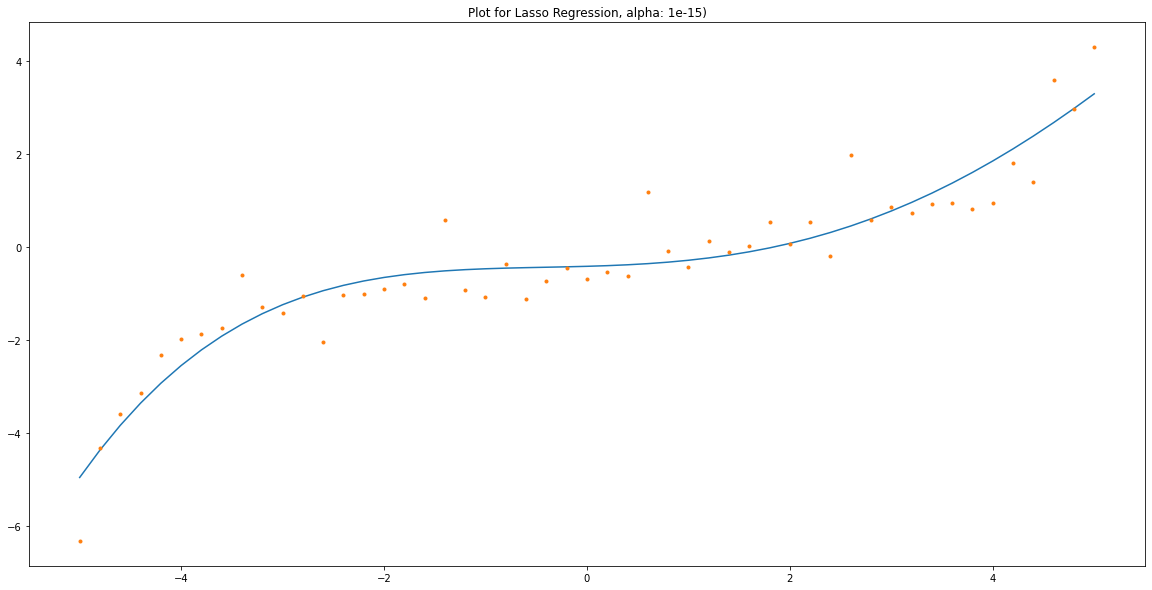

In [18]:
features, lasso_coef_matrix = feature_selection(4,lasso_alpha)     #call a feture_selection function with all powers upto 4 used

#iterate for different values of alpha and update the parameters
for i in range(3):
    lasso_coef_matrix.iloc[i,:], submission = lasso_model(train_data,test_data,submission,features,lasso_alpha[i])
    
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
print("Lasso Regression with X power terms upto 4")
lasso_coef_matrix

In [19]:
#update the results to the 'submission.csv' file
#Y_test_ridge is for features upto 7th power of X and alpha=1e-15
#Y_test_lasso is for features upto 4th power of X and alpha=1e-15

submission.to_csv('submission.csv',index=False)
submission.head(10)

,X,Y_test_linear,Y_test_ridge,Y_test_lasso
0,-6,-3.6,-23,-8.9
1,-6,-3.6,-23,-8.8
2,-6,-3.6,-23,-8.8
3,-6,-3.6,-22,-8.7
4,-6,-3.6,-22,-8.7
5,-6,-3.6,-22,-8.6
6,-5.9,-3.6,-22,-8.6
7,-5.9,-3.6,-21,-8.6
8,-5.9,-3.6,-21,-8.5
9,-5.9,-3.5,-21,-8.5
